# Implementing Convolutional Neural Network (CNN) from scratch
**By - Ashish Ahuja**

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

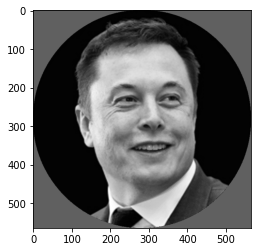

(564, 565)


In [ ]:
image = cv2.imread("musk.png", cv2.IMREAD_GRAYSCALE)/255 #test image
plt .imshow(image, cmap = "gray")
plt.show()
print(image.shape)

**1. Convolution Block**

In [ ]:
class Conv_Operation:
    def __init__(self, num_filters, filter_size): #constructor
        self.num_filters = num_filters
        self.filter_size = filter_size
        self.conv_filter = np.random.randn(num_filters, filter_size, filter_size) / (filter_size*filter_size)
        
    def extract_img(self, image): #to extract patches from the image (generator function)
        h, w = image.shape
        self.image = image
        for i in range(h-self.filter_size+1):
            for j in range(w-self.filter_size+1):
                image_patch = image[i : (i+self.filter_size), j : (j+self.filter_size)]
                yield image_patch, i, j
                
    def forward_propagation(self, image): #forward propagation step
        h, w = image.shape
        conv_output = np.zeros((h-self.filter_size+1, w-self.filter_size+1, self.num_filters))
        for image_patch, i, j in self.extract_img(image):
            conv_output[i, j] = np.sum(image_patch*self.conv_filter, axis = (1,2))
        return conv_output
    
    def backward_propagation(self, maxpool_out, learning_rate): #backward propagation step
        update = np.zeros(self.conv_filter.shape)
        for image_patch, i, j in self.extract_img(self.image):
            for f in range(self.num_filters):
                update[f] = update[f]+(image_patch*maxpool_out[i,j,f])
        self.conv_filter = self.conv_filter-(learning_rate*update) #update filter weights
        return update

**Testing Convolution Operation**

(558, 559, 20)


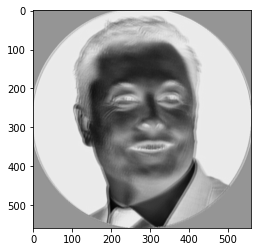

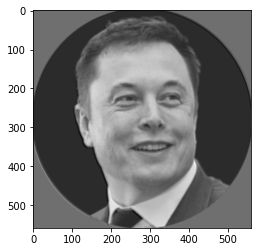

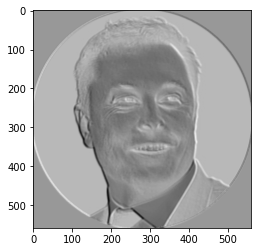

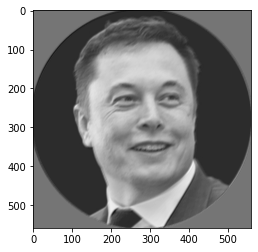

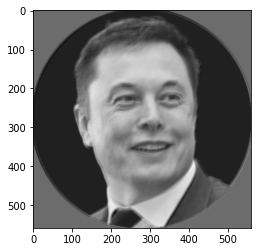

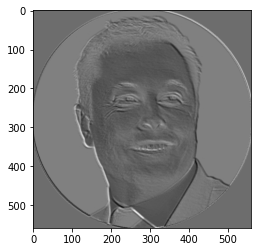

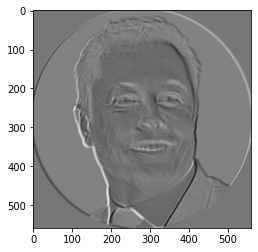

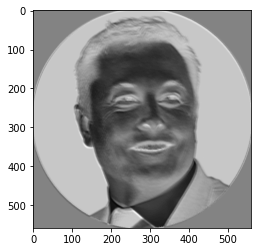

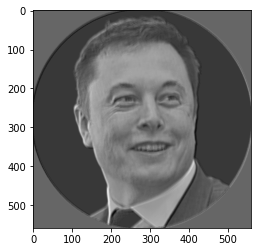

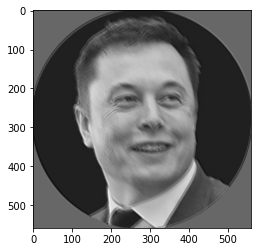

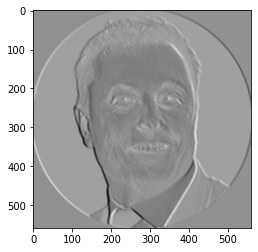

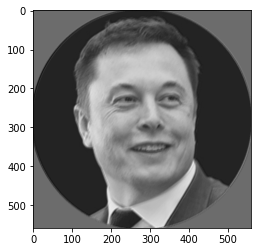

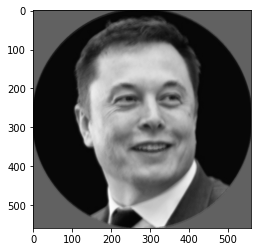

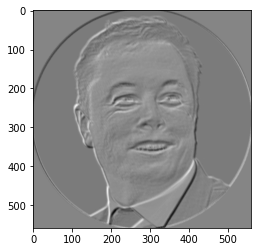

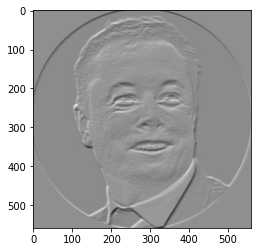

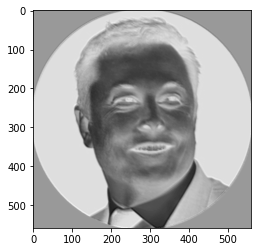

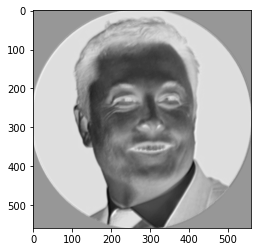

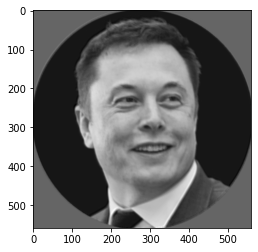

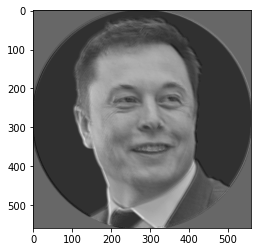

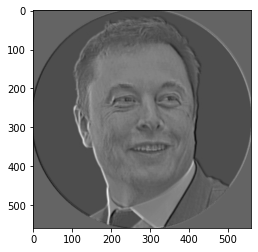

In [ ]:
conv = Conv_Operation(20,7) #20 = number of filters, 7 = 7x7 filter
coutput = conv.forward_propagation(image)
print(coutput.shape)
for i in range(20):
    plt.imshow(coutput[:,:,i], cmap = "gray")
    plt.show()

**2. Maxpool Block** 

In [ ]:
class Maxpool_Operation:
    def __init__(self, filter_size): #constructor
        self.filter_size = filter_size
        
    def img_red(self, image): #to reduce the image size (generator function)
        new_h = image.shape[0]//self.filter_size
        new_w = image.shape[1]//self.filter_size
        self.image = image
        for i in range(new_h):
            for j in range(new_w):
                image_patch = image[(i*self.filter_size) : (i*self.filter_size+self.filter_size) , (j*self.filter_size) : (j*self.filter_size+self.filter_size)]
                yield image_patch, i, j
                
    def forward_propagation(self, image): #forward propagation step
        h, w, nf = image.shape
        mx_output = np.zeros((h//self.filter_size, w//self.filter_size, nf))
        for image_patch, i, j in self.img_red(image):
            mx_output[i,j] = np.amax(image_patch, axis = (0,1))
        return mx_output
    
    def backward_propagation(self, soft_out): #backward propagation step
        op = np.zeros(self.image.shape)
        for image_patch, i, j in self.img_red(self.image):
            h, w, nf = image_patch.shape
            maxval = np.amax(image_patch, axis = (0,1))
            for x in range(h):
                for y in range(w):
                    for z in range(nf):
                        if image_patch[x,y,z] == maxval[z]:
                            op[i*self.filter_size + x, j*self.filter_size + y, z] = soft_out[i, j, z]
            return  op

**Testing Maxpool Operation**

(55, 55, 20)


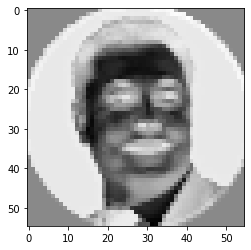

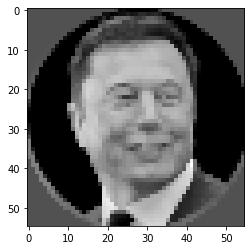

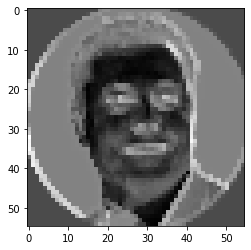

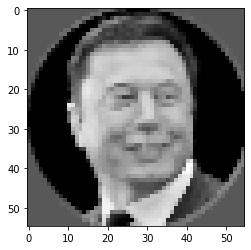

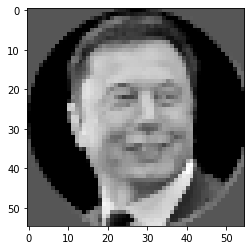

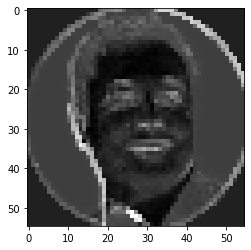

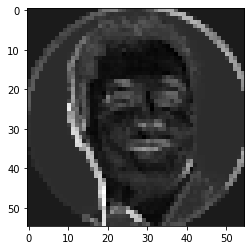

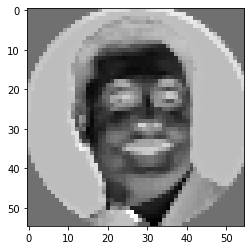

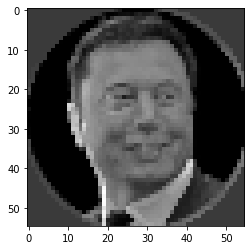

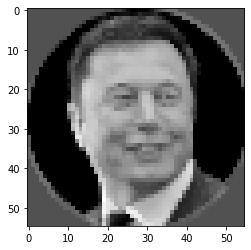

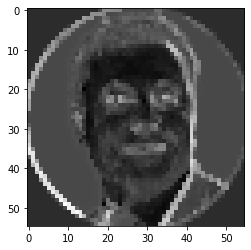

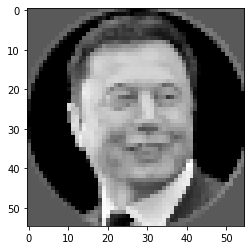

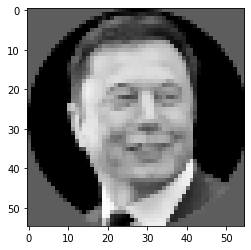

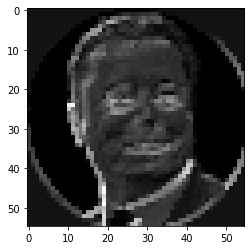

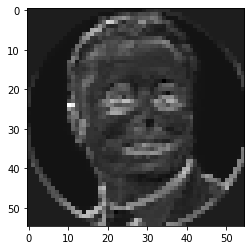

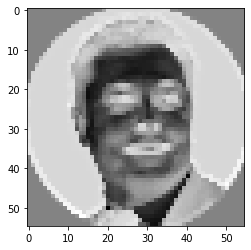

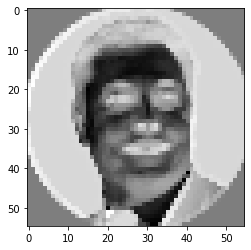

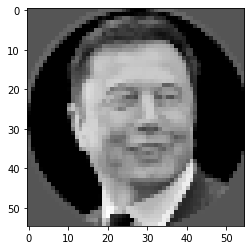

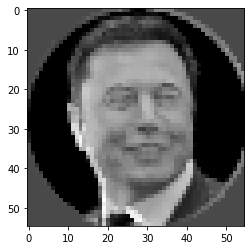

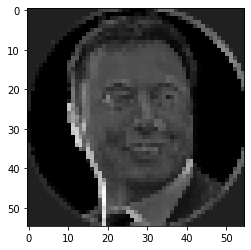

In [ ]:
maxp = Maxpool_Operation(10) #10 = 10x10 filter
moutput = maxp.forward_propagation(coutput)
print(moutput.shape)
for i in range(20):
    plt.imshow(moutput[:,:,i], cmap = "gray")
    plt.show()

**3. Softmax Block**

In [ ]:
class Softmax_Operation:
    def __init__(self, Input, soft_nodes): #constructor
        self.weight = np.random.randn(Input, soft_nodes)/Input
        self.bias = np.zeros(soft_nodes)
        
    def forward_propagation(self, image): #forward propagation step
        self.original_shape = image.shape
        flatimg = image.flatten()
        self.flat = flatimg
        output = np.dot(flatimg, self.weight)+self.bias
        self.out = output
        expo = np.exp(output)
        return expo/np.sum(expo, axis = 0)
    
    def backward_propagation(self, output, learning_rate): #backward propagation step
        for i,grad in enumerate(output):
            if grad == 0:
                continue
            transformation = np.exp(self.out)
            tot = np.sum(transformation)
            dy = -transformation[i]*transformation/(tot**2)
            dy[i] = transformation[i]*(tot-transformation[i])/(tot**2)
            dzw = self.flat
            dzb = 1
            dzinp = self.weight
            dlz = grad*dy
            dlw = dzw[np.newaxis].T @ dlz[np.newaxis]
            dlb = dlz*dzb
            dlinp = dzinp @ dlz
        self.weight = self.weight-(learning_rate*dlw)
        self.bias = self.bias - (learning_rate*dlb)
        return dlinp.reshape(self.original_shape)

**Testing Softmax Operation**

In [ ]:
soft = Softmax_Operation(moutput.shape[0]*moutput.shape[1]*moutput.shape[2], 10) #10 = 10 output classes
soutput = soft.forward_propagation(moutput)
print(soutput) #prints random values as we are not performing back propagation

[0.09998976 0.09995875 0.10000999 0.100001   0.10004035 0.10005916
 0.09996401 0.09997897 0.09999435 0.10000366]


**Performing digit recognition task using our self implemented functions**

In [ ]:
import tensorflow as tf #just to get the dataset
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
train_images = x_train[:2000]
train_labels = y_train[:2000]
test_images = x_test[:2000]
test_labels = y_test[:2000]

In [ ]:
conv = Conv_Operation(8,3)
pool = Maxpool_Operation(2)
softmax = Softmax_Operation(13*13*8, 10)
def cnn_forward_prop(image, label):
  outp = conv.forward_propagation((image/255) - 0.5)
  outp = pool.forward_propagation(outp)
  outp = softmax.forward_propagation(outp)
  cross_entropy_loss = -np.log(outp[label])
  accuracy = 1 if np.argmax(outp) == label else 0
  return outp, cross_entropy_loss, accuracy

def train(image, label, learning_rate = 0.005):
  outp, loss, acuracy = cnn_forward_prop(image, label)
  grad = np.zeros(10)
  grad[label] = -1/outp[label]
  grad_back = softmax.backward_propagation(grad, learning_rate)
  grad_back = pool.backward_propagation(grad_back)
  grad_back = conv.backward_propagation(grad_back, learning_rate)
  return loss, acuracy

**Training CNN**

In [ ]:
for epoch in range(5):
  print("Epoch %d -->"%(epoch+1))
  shuffle = np.random.permutation(len(train_images))
  train_images = train_images[shuffle]
  train_labels = train_labels[shuffle]
  loss = 0.0
  correct = 0
  for i, (img, label) in enumerate(zip(train_images, train_labels)):
    if i%100 == 0:
      print("%d steps out of 100 steps: Average Loss %.3f and Accuracy: %d%%" %(i+1, loss/100, correct))
      loss = 0.0
      correct = 0
    l, ac = train(img, label)
    loss = loss+l
    correct = correct+ac

Epoch 1 -->
1 steps out of 100 steps: Average Loss 0.000 and Accuracy: 0%
101 steps out of 100 steps: Average Loss 2.232 and Accuracy: 20%
201 steps out of 100 steps: Average Loss 2.102 and Accuracy: 31%
301 steps out of 100 steps: Average Loss 2.019 and Accuracy: 30%
401 steps out of 100 steps: Average Loss 1.960 and Accuracy: 45%
501 steps out of 100 steps: Average Loss 1.912 and Accuracy: 46%
601 steps out of 100 steps: Average Loss 1.712 and Accuracy: 61%
701 steps out of 100 steps: Average Loss 1.727 and Accuracy: 59%
801 steps out of 100 steps: Average Loss 1.602 and Accuracy: 70%
901 steps out of 100 steps: Average Loss 1.489 and Accuracy: 69%
1001 steps out of 100 steps: Average Loss 1.542 and Accuracy: 69%
1101 steps out of 100 steps: Average Loss 1.481 and Accuracy: 68%
1201 steps out of 100 steps: Average Loss 1.426 and Accuracy: 75%
1301 steps out of 100 steps: Average Loss 1.349 and Accuracy: 74%
1401 steps out of 100 steps: Average Loss 1.342 and Accuracy: 66%
1501 steps 

**Testing CNN**

In [ ]:
loss = 0
correct = 0
for img, label in zip(train_images, train_labels):
  _, l, ac = cnn_forward_prop(img, label)
  loss = loss+l
  correct = correct+ac
ntrain = len(train_images)
print("Train loss --> ", loss/ntrain)
print("Train accuracy --> ", correct/ntrain)
loss = 0
correct = 0
for img, label in zip(test_images, test_labels):
  _, l, ac = cnn_forward_prop(img, label)
  loss = loss+l
  correct = correct+ac
ntest = len(test_images)
print("Test loss --> ", loss/ntest)
print("Test accuracy --> ", correct/ntest)

Train loss -->  0.5599456675732397
Train accuracy -->  0.8805
Test loss -->  0.7394267663394645
Test accuracy -->  0.8155


**Visualizing some test cases**

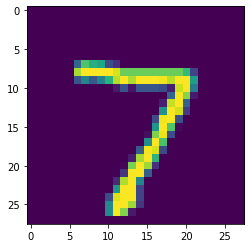

Predicted label is -->  7


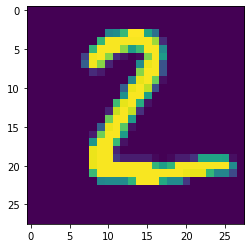

Predicted label is -->  2


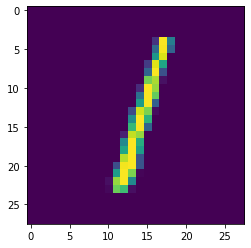

Predicted label is -->  1


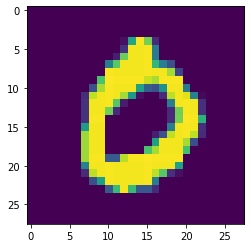

Predicted label is -->  0


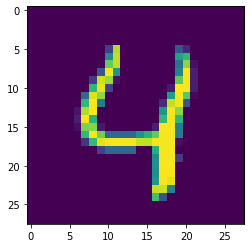

Predicted label is -->  4


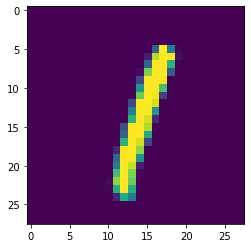

Predicted label is -->  1


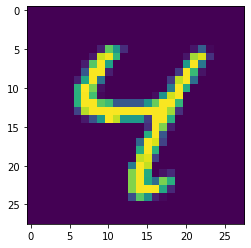

Predicted label is -->  4


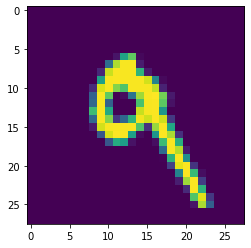

Predicted label is -->  9


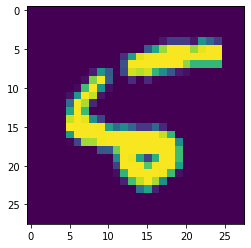

Predicted label is -->  5


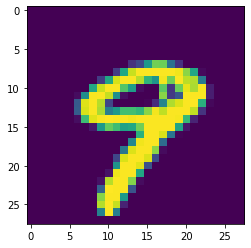

Predicted label is -->  9


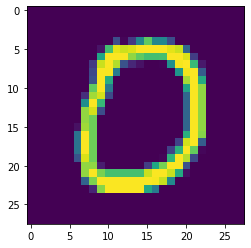

Predicted label is -->  0


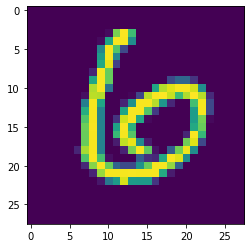

Predicted label is -->  2


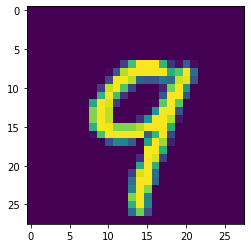

Predicted label is -->  9


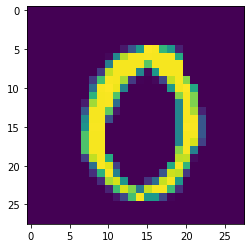

Predicted label is -->  0


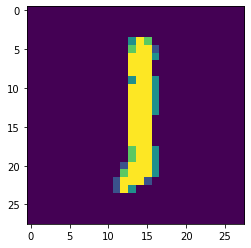

Predicted label is -->  1


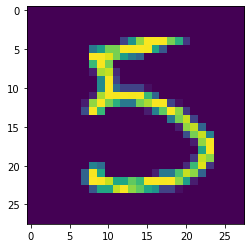

Predicted label is -->  5


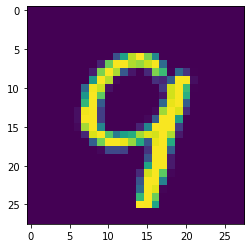

Predicted label is -->  9


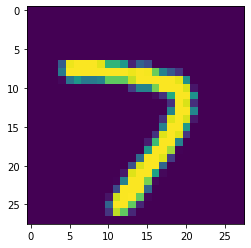

Predicted label is -->  7


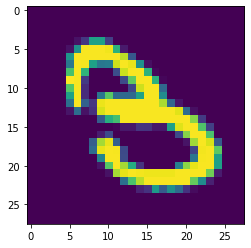

Predicted label is -->  5


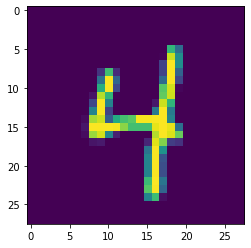

Predicted label is -->  4


In [ ]:
for i in range(20): #to show the first 20 images of the dataset
  plt.imshow(test_images[i])
  plt.show()
  prediction, l, ac = cnn_forward_prop(test_images[i], label)
  print("Predicted label is --> ", np.argmax(prediction))